# Extract the Bounding Boxes and Instance Masks for Supervisely Persons Data

The JSON annotation files for each image in the Supervisely Persons dataset does not contain bounding box information (specifically $x_{min}$, $x_{max}$, $y_{min}$ and $y_{max}$). These are required for the TensorFlow Object Detection API and therefore need to be extracted when creating the TFRecords.

This notebook explores how to resize images and segmentation masks and extract bounding boxes.

## Import Libraries

In [1]:
import sys
import json
import zlib
import base64
import glob
import os
import io

import numpy as np
import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import PIL
import PIL.Image

print(f'Python version: {sys.version.split()[0]}')
print(f'Numpy version: {np.__version__}')
print(f'Matplotlib version: {matplotlib.__version__}')
print(f'OpenCV version: {cv.__version__}')
print(f'Pillow version: {PIL.__version__}')

Python version: 3.6.8
Numpy version: 1.16.2
Matplotlib version: 3.0.2
OpenCV version: 4.0.1
Pillow version: 5.4.1


## 1. Load the Image and Annotation File

Images and annotations are stored in seperate files.

In [2]:
DATASET_PATH = '/media/adam/HDD Storage/Datasets/supervisely-persons/' # Path to the dataset root
ANN_FILE_PATH = 'ds2/ann/pexels-photo-273037.json' # Path from the dataset root to the annotation file
IMG_FILE_PATH = 'ds2/img/pexels-photo-273037.png' # Path from the dataset root to the image file

In [3]:
def load_image_into_numpy_array(image):
    """
    Load a PIL image into a numpy array.

    Args:
        image: A PIL image.

    Returns:
        array: A 2D numpy array of the image.
    """
    (im_width, im_height) = image.size
    array = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

    return array

In [4]:
# Load annotation file
with open(DATASET_PATH + ANN_FILE_PATH, 'r') as f:
    annotations_dict = json.load(f)

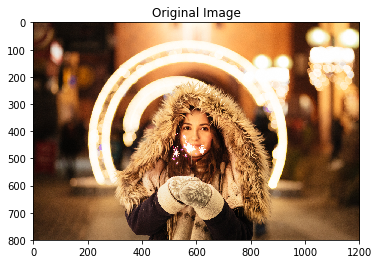

In [5]:
# Load image
image = PIL.Image.open(DATASET_PATH + IMG_FILE_PATH)

plt.title('Original Image')
plt.imshow(image)
plt.show()

## 2. Crop the Image

The size of the images captured by the RealSense D435 camera are 640x480 pixels. To improve the quality of the results and reduce memory usage during training, we resize the images in our dataset.

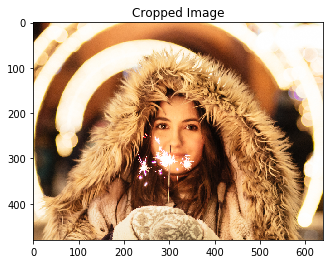

In [6]:
MAX_WIDTH = 640
MAX_HEIGHT = 480

image_width_og, image_height_og = image.size
left = (image_width_og - MAX_WIDTH) // 2
top = (image_height_og - MAX_HEIGHT) // 2
right = (image_width_og + MAX_WIDTH) // 2
bottom = (image_height_og + MAX_HEIGHT) // 2
image = image.crop((left, top, right, bottom))
image_width_crop, image_height_crop = image.size

plt.title('Cropped Image')
plt.imshow(image)
plt.show()

## 3. Convert Serialised Mask to Mask

The instance masks provided for the supervisely dataset are not whole-image masks, therefore, they will need to be padded.

The following functions are provided by Supervisely ([here](https://docs.supervise.ly/ann_format/)) to convert between serialised masks and masks.

In [7]:
def base64_2_mask(s):
    """
    Convert from a base64 encoded string to numpy mask.
    """
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    mask = cv.imdecode(n, cv.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    
    return mask

def mask_2_base64(mask):
    """
    Convert from a numpy mask to a base64 encoded string.
    """
    img_pil = Image.fromarray(np.array(mask, dtype=np.uint8))
    img_pil.putpalette([0,0,0,255,255,255])
    bytes_io = io.BytesIO()
    img_pil.save(bytes_io, format='PNG', transparency=0, optimize=0)
    bytes = bytes_io.getvalue()
    
    return base64.b64encode(zlib.compress(bytes)).decode('utf-8')

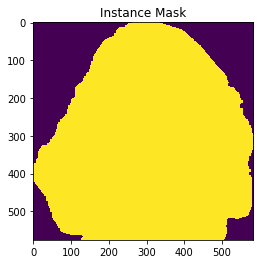

In [8]:
instance = annotations_dict['objects'][0]
mask = base64_2_mask(instance['bitmap']['data']).astype(np.uint8)
plt.title('Instance Mask')
plt.imshow(mask)
plt.show()

## 4. Obtain Bounding Box in Cropped Image

We want arrays for each of $x_{min}$, $x_{max}$, $y_{min}$ and $y_{max}$.

*Note: mask/image origins are the top-left corners.*

In [9]:
# Get original mask location and dimensions
mask_origin_og = instance['bitmap']['origin']
mask_height_og = mask.shape[0]
mask_width_og = mask.shape[1]

# Update mask location and dimensions for cropped image
mask_origin_crop = (max(mask_origin_og[0] - left, 0), max(mask_origin_og[1] - top, 0))
mask_height_crop = min(mask_height_og, image_height_crop - mask_origin_crop[1])
mask_width_crop = min(mask_width_og, image_width_crop - mask_origin_crop[0])

# Get bounding box coords
x_min = mask_origin_crop[0]
x_max = mask_origin_crop[0] + mask_width_crop
y_min = mask_origin_crop[1]
y_max = mask_origin_crop[1] + mask_height_crop

In [10]:
print(x_min)
print(x_max)
print(y_min)
print(y_max)

17
600
63
480


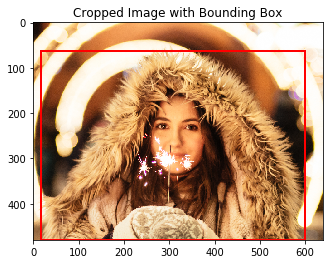

In [11]:
plt.title('Cropped Image with Bounding Box')
plt.imshow(image)
ax = plt.gca()
rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

## 5. Generate Whole Image Instance Mask

For image segmentation, the TensorFlow Object Detection API requires object masks which meet the following requirements:
    
* **Masks must be whole-image masks** (i.e. the dimensions of the masks must match the dimensions of the image).
* **Provide a mask for each object** to be detected in the image.
* Preferably masks should be in **PNG format** (to save space).
* Masks must be **encoded 1 for pixels of the object, 0 otherwise**.

Therefore, since the persons dataset masks are not whole-image masks, we must pad them.

In [12]:
def crop_centre(image, width, height):
    """
    Takes an image as a numpy array and crops to the centre region.

    Args:
        image: A numpy array of the image.
        width: The desired width of the cropped image.
        height: The desired height of the cropped image.

    Returns:
        image_crop: A numpy array of the cropped image.
    """
    y, x = image.shape[:2]

    start_x = x // 2 - (width // 2)
    start_y = y // 2 - (height // 2)
    image_crop = image[start_y:start_y + height, start_x:start_x + width]

    return image_crop

(576, 297) (576, 583)


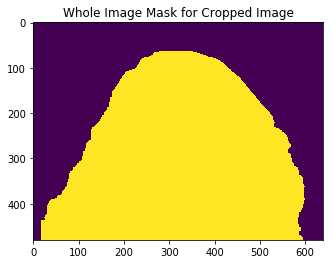

In [13]:
# Create padding
left_pad = np.zeros((mask_height_og, mask_origin_og[0]))
right_pad = np.zeros((mask_height_og, image_width_og - mask_width_og - mask_origin_og[0]))
top_pad = np.zeros((mask_origin_og[1], image_width_og))
bottom_pad = np.zeros((image_height_og - mask_height_og - mask_origin_og[1], image_width_og))

# Append and prepend padding
print(left_pad.shape, mask.shape)
mask = np.hstack((left_pad, mask))
mask = np.hstack((mask, right_pad))
mask = np.vstack((top_pad, mask))
mask = np.vstack((mask, bottom_pad))

# Crop mask
mask = crop_centre(mask, MAX_WIDTH, MAX_HEIGHT)

plt.title('Whole Image Mask for Cropped Image')
plt.imshow(mask)
plt.show()

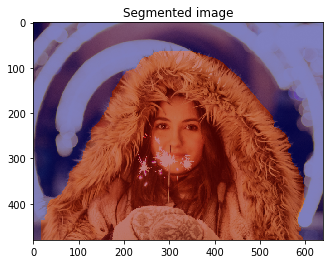

In [14]:
plt.title("Segmented image")
plt.imshow(image)
plt.imshow(mask, cmap='jet', alpha=0.5)
plt.show()

In [24]:
# Check image and mask dimensions are equal
print(image.size == (mask.shape[1], mask.shape[0]))

True


In [15]:
# Convert instance mask to byte array
img = PIL.Image.fromarray(mask).convert('1')
output = io.BytesIO()
img.save(output, format='PNG')

## 6. Generating `trainval.txt`

The Mask R-CNN model also requires a list of paths to all train and test images. The following explores how to do this.

In [16]:
examples = []
for dataset_dir in [f.name for f in os.scandir(DATASET_PATH) if f.is_dir()]:
    annotations_path = os.path.join(DATASET_PATH, dataset_dir, 'ann')
    examples += [os.path.join(dataset_dir, 'ann', f.name) for f in os.scandir(annotations_path)]

In [17]:
examples[:10]

['ds1/ann/bodybuilder-weight-training-stress-38630.json',
 'ds1/ann/bow-tie-businessman-fashion-man.json',
 'ds1/ann/bow-tie-fashion-man-person.json',
 'ds1/ann/boy-african-africa-child-47080.json',
 'ds1/ann/brothers-family-siblings-boys-50692.json',
 'ds1/ann/brown-brunette-female-finger-41551.json',
 'ds1/ann/brunette-cute-fashion-female-41366.json',
 'ds1/ann/child-children-girl-happy.json',
 'ds1/ann/city-man-person-lights.json',
 'ds1/ann/city-woman-view-blue-sky.json']